Treating layer(s) 2 incoherently
Calculating RAT...
Calculating absorption profile...
Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...
Solving QE of the solar cell...


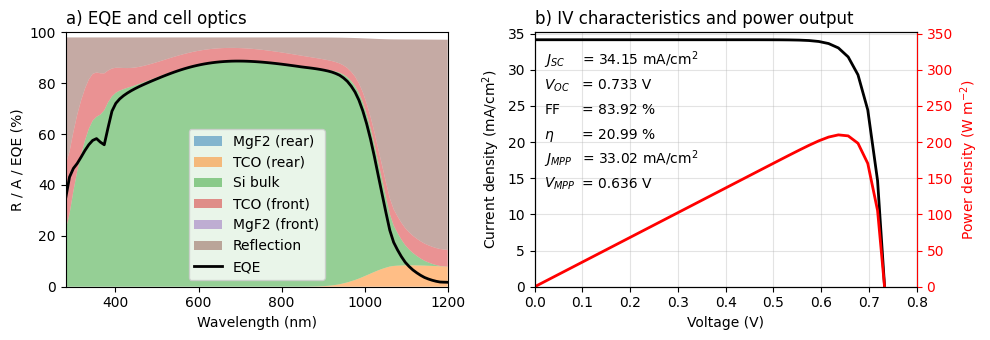

Treating layer(s) 2 incoherently
Calculating RAT...
Calculating absorption profile...
Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...
0.0001 0.1937913542429311 0.8293277678586162
Treating layer(s) 2 incoherently
Calculating RAT...
Calculating absorption profile...
Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...
0.001 0.2099118260145833 0.839161927430213
Treating layer(s) 2 incoherently
Calculating RAT...
Calculating absorption profile...
Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...
0.01 0.21562566099433145 0.8532963963330291
Treating layer(s) 2 incoherently
Calculating RAT...
Calculating absorption profile...
Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...
0.1 0.21633754539856803 0.8555553457333414


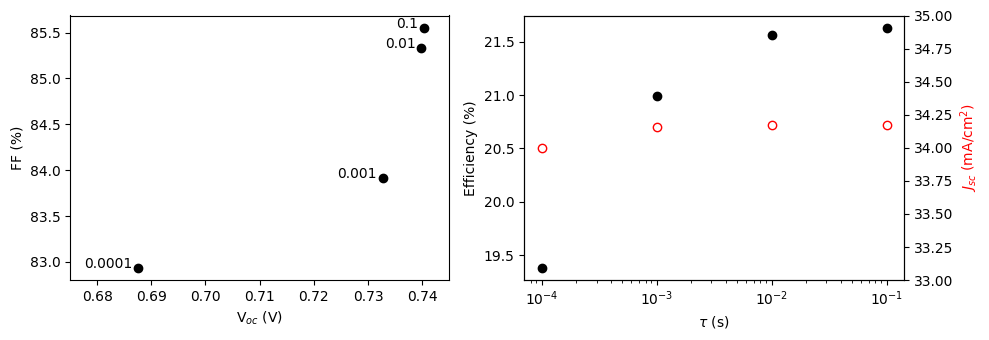

In [1]:
from solcore.solar_cell import SolarCell, Junction, Layer
from solcore.state import State
from solcore.solar_cell_solver import solar_cell_solver
import numpy as np
from solcore.light_source import LightSource
from scipy.special import erfc

import matplotlib.pyplot as plt

from solcore import material, si

d_bulk = 130e-6

Air = material("Air")()
MgF2 = material("MgF2")()
Ag = material("Ag")()

Si_pn = material("Si")(electron_mobility=si("1e4cm2"), hole_mobility=si("1e3cm2"),
                       electron_minority_lifetime=0.001, hole_minority_lifetime=0.001)

wavelengths = np.linspace(280, 1200, 100)*1e-9

TCO = material('ITO2')()

front_materials = [Layer(80e-9, MgF2), Layer(55e-9, TCO)]

back_materials = [Layer(55e-9, TCO),
                  Layer(120e-9, MgF2)]

options = State()
options.wavelength = wavelengths
options.optics_method = 'TMM'
options.light_iv = True
options.T = 298

options.light_source = LightSource(source_type="standard",
                           version="AM1.5g", x=options.wavelength)

options.voltages = np.linspace(0, 0.8, 40)
options.internal_voltages = options.voltages
options.mpp = True
options.no_back_reflection = False

nD = si("1e20cm-3")
nA = si("1e19cm-3")
bulk_doping = si("5e15cm-3") # n type bulk

# rear junction (n-type)
def doping_profile_func(x):

    L = d_bulk

    doping_profile = - nA * erfc(x/150e-9) # characteristic depth of 150 nm

    doping_profile_rear = nD * erfc((L - x)/200e-9) # characteristic depth of 200 nm

    return doping_profile + doping_profile_rear + bulk_doping

surface_recomb = dict(sn_front=si('5e3 cm s-1'),  # important
                          sp_front=si('1e4 cm s-1'),
                          sn_rear=si('1e4 cm s-1'),
                          sp_rear=si('1e4 cm s-1'))  # important

Si_junction = [Junction([Layer(d_bulk, Si_pn)],
                        doping_profile=doping_profile_func, kind='sesame_PDD',
                        **surface_recomb,
                        )
               ]

Si_cell = SolarCell(front_materials +
                     Si_junction +
                     back_materials,
                    shading=0.02,
                    substrate=Ag,
                    )

solar_cell_solver(Si_cell, 'iv', options)

solar_cell_solver(Si_cell, 'qe', options)

result_stack = np.vstack([Si_cell.reflected, [layer.layer_absorption for layer in Si_cell]])

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(10, 3.5))
ax.stackplot(wavelengths * 1e9, 100 * result_stack[::-1], linewidth=0.5, alpha=0.5,
             labels=['MgF2 (rear)', 'TCO (rear)', 'Si bulk', 'TCO (front)', 'MgF2 (front)',
                     'Reflection'])
ax.plot(wavelengths * 1e9, 100 * Si_cell(0).eqe(wavelengths), '-k', linewidth=2,
        label='EQE')

ax.set_xlim(280, 1200)
ax.set_ylim(0, 100)
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("R / A / EQE (%)")
ax.set_title('a) EQE and cell optics', loc='left')
ax.legend()
# plt.show()

jsc = Si_cell.iv.Isc / 10

ax2.plot(Si_cell.iv['IV'][0], Si_cell.iv['IV'][1] / 10, '-', label='IV',
         linewidth=2, color='k')

ax2.set_ylim(0, 1.03 * jsc)
ax2.set_xlim(np.min(options.voltages), np.max(options.voltages))
ax2.set_xlabel('Voltage (V)')
ax2.set_ylabel('Current density (mA/cm$^2$)')
ax2.set_title('b) IV characteristics and power output', loc='left')

ax3 = ax2.twinx()
ax3.plot(options.voltages, Si_cell.iv['IV'][0] * Si_cell.iv['IV'][1],
         '-r', label='Power', linewidth=2)
ax3.set_ylabel('Power density (W m$^{-2}$)')
ax3.set_ylim(0, 1.03 * jsc * 10)

ax3.spines['right'].set_color('r')
ax3.yaxis.label.set_color('r')
ax3.tick_params(axis='y', colors='r')

ax2.set_axisbelow(True)
ax3.set_axisbelow(True)

ax2.text(0.02, 0.9 * jsc, r'$J_{SC}$', zorder=5)
ax2.text(0.02, 0.8 * jsc, r'$V_{OC}$')
ax2.text(0.02, 0.7 * jsc, 'FF')
ax2.text(0.02, 0.6 * jsc, r'$\eta$')
ax2.text(0.02, 0.5 * jsc, r'$J_{MPP}$')
ax2.text(0.02, 0.4 * jsc, r'$V_{MPP}$')

ax2.text(0.1, 0.9 * jsc, r'= {:.2f} mA/cm$^2$'.format(jsc))
ax2.text(0.1, 0.8 * jsc, r'= {:.3f} V'.format(Si_cell.iv.Voc))
ax2.text(0.1, 0.7 * jsc, '= {:.2f} %'.format(Si_cell.iv.FF * 100))
ax2.text(0.1, 0.6 * jsc, r'= {:.2f} %'.format(Si_cell.iv.Eta * 100))
ax2.text(0.1, 0.5 * jsc, r'= {:.2f} mA/cm$^2$'.format( Si_cell.iv.Impp / 10))
ax2.text(0.1, 0.4 * jsc, r'= {:.3f} V'.format(Si_cell.iv.Vmpp))
ax2.grid(which='major', alpha=0.35)

ax3.grid(False)
plt.tight_layout()

plt.show()

# Scan through lifetimes

lifetime_exp = np.arange(-4, 0, 1)

lifetimes = 10.0**lifetime_exp

cell_results = np.zeros(([len(lifetimes), 4])) # save efficiency, FF, Voc, Jsc

for i1, lt in enumerate(lifetimes):

    options.recalculate_absorption = True

    Si_pn = material("Si")(electron_mobility=si("1e4cm2"), hole_mobility=si("1e3cm2"),
                           electron_minority_lifetime=lt, hole_minority_lifetime=lt)

    Si_junction = [Junction([Layer(d_bulk, Si_pn)],
                            doping_profile=doping_profile_func, kind='sesame_PDD',
                            **surface_recomb)]

    Si_cell = SolarCell(front_materials +
                         Si_junction +
                         back_materials,
                        shading=0.02,
                        substrate=Ag,
                        )

    solar_cell_solver(Si_cell, 'iv', options)

    cell_results[i1] = np.array([100*Si_cell.iv.Eta, 100*Si_cell.iv.FF, Si_cell.iv.Voc, Si_cell.iv.Isc/10])

    print(lt, Si_cell.iv.Eta, Si_cell.iv.FF)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3.5))

ax1.plot(cell_results[:, 2], cell_results[:, 1], 'ko')

for i, lt in enumerate(lifetimes):
    ax1.annotate(str(lt), (cell_results[i, 2] - 0.001, cell_results[i, 1]), ha='right')

ax1.set_xlabel(r'V$_{oc}$ (V)')
ax1.set_ylabel('FF (%)')
ax1.set_xlim(0.675, 0.745)

ax2.semilogx(lifetimes, cell_results[:, 0], 'o', color='k')
ax2.set_ylabel('Efficiency (%)')
ax3 = ax2.twinx()
ax3.plot(lifetimes, cell_results[:, 3], 'o', color='r', markerfacecolor='none')
ax3.set_ylim(33, 35)
ax3.set_ylabel(r'$J_{sc}$ (mA/cm$^2$)', color='r')

ax2.set_xlabel(r'$\tau$ (s)')

plt.tight_layout()
plt.show()